# 勾配降下法によるロジスティック回帰モデルの学習を自動微分ライブラリ（PyTorch）を用いて実装した例

## モジュールのインストール

Google Colabに標準でインストールされていないモジュールを最初にインストールしておく

In [1]:
!pip install torchviz
!pip install japanize-matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=c36a412eacee3ff697d7b731d0b66fa8c684400e51507895581be01d8efcca18
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=31c544c797aa665ac84b2b655085cbd20b824d9f245658a643f1f172869a4f0e
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## 必要なモジュールの読み込み

可視化用のモジュール (Matplotlib) と自動微分の計算用モジュール (PyTorch)

In [2]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import japanize_matplotlib

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F


print('PyTorch version: ' + torch.__version__)

PyTorch version: 2.1.0+cu121


## アルゴリズムの実行に使うトイデータの生成とプロット

2次元空間上の異なる2つの正規分布からサンプリングしたデータ点 (各クラス100点ずつ，合計$N = 200$) を用いる．

Text(0, 0.5, '特徴量2')

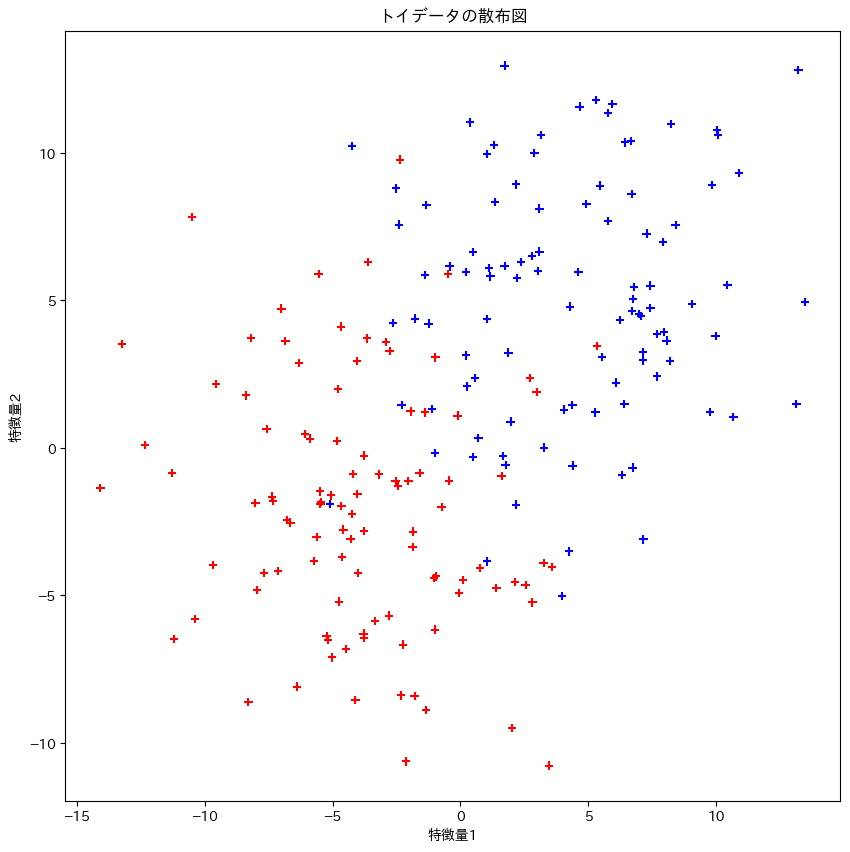

In [3]:
def generate_toydata(N1=100, N2=100):
    data1 = torch.randn(N1, 2) * 4.0 + torch.tensor([[5.0, 5.0]])
    data2 = torch.randn(N2, 2) * 4.0 + torch.tensor([[-4.0, -2.0]])

    data = torch.cat([data1, data2])
    labels = torch.cat([torch.zeros(N1), torch.ones(N2)])

    return data, labels


X, t = generate_toydata()

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, marker='+', cmap='bwr')
plt.title('トイデータの散布図')
plt.xlabel('特徴量1')
plt.ylabel('特徴量2')

## モデルとデータ間の損失関数 (交差エントロピー) の計算グラフを描画

* データ： $\{(\mathbf x_n, t_n)\}_{n=1}^N$
* モデル:
$$
\begin{align*}
y &= \frac{1}{1 + \exp\{-(\mathbf w^\top \mathbf x+b)\}} \\
&=\frac{1}{1 + \exp\{-(w_1x_1 + w_2x_2 + b)\}}
\end{align*}
$$
* 損失関数：
$$
\begin{align*}
L(\mathbf w, b) &= \sum_{n=1}^N \left\{-t_n \log y(\mathbf x_n) -(1 - t_n) \log (1 - y(\mathbf x_n)) \right\}
\end{align*}
$$

※ 実際には，対数関数の中身がゼロになるのを防ぐため，微小定数 $\varepsilon$ を導入している．

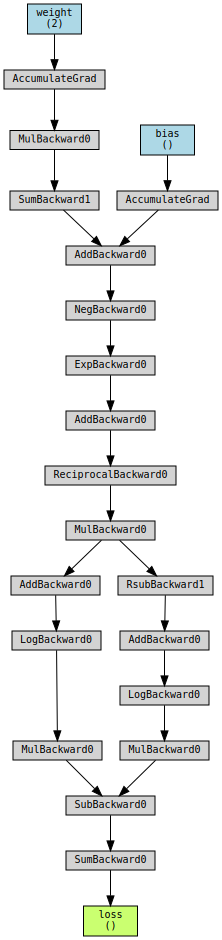

In [4]:
from torchviz import make_dot

# 対数の中身がゼロになるのを防ぐための定数
eps = 1e-9

# パラメタの初期値を設定（requires_gradは勾配を計算する必要がある変数，つまりパラメタであることを意味する）
w = torch.tensor([1.0, 1.0], requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

y_pred = 1 / (1 + torch.exp(-(torch.sum(w * X, dim=1) + b)))
loss = torch.sum(
    -t * torch.log(y_pred + eps) - (1.0 - t) * torch.log(1.0 - y_pred + eps)
)

# 計算グラフの生成
dot = make_dot(loss, params={'weight': w, 'bias': b, 'loss': loss})
dot.graph_attr.update(size='12,24')

# 計算グラフの図をファイルに保存
dot.render('comp_graph', format='png')
dot.render('comp_graph', format='svg')

dot

## 勾配降下法によるロジスティック回帰モデルの学習 （損失関数を最小にする $\mathbf w, b$ を探す）

In [5]:
# 対数の中身がゼロになるのを防ぐための定数
eps = 1e-9

# 学習率
lr = 1e-3

# パラメタの初期値を設定（requires_gradは勾配を計算する必要がある変数，つまりパラメタであることを意味する）
w = torch.tensor([1.0, 1.0], requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

# 勾配降下法の実行
for k in tqdm(range(5000)):
    # 各入力データに対するモデル予測の計算
    y_pred = 1 / (1 + torch.exp(-(torch.sum(w * X, dim=1) + b)))
    # 損失関数の計算（モデルによるラベルの予測と真のラベルの誤差を交差エントロピーで計算する）
    loss = torch.sum(-t * torch.log(y_pred + eps) - (1.0 - t) * torch.log(1.0 - y_pred + eps))

    # 計算グラフを loss ノードから w, b ノードに向かって逆に辿ることで微分値を計算
    w.grad = torch.tensor([0.0, 0.0])
    b.grad = torch.tensor(0.0)
    loss.backward()

    # 自動微分によって計算した微分値でパラメタの値を更新する
    # (ここでは計算グラフを作らないようにするため with torch.no_grad() の中で行う)
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

100%|██████████| 5000/5000 [00:02<00:00, 1714.86it/s]


In [6]:
w, b, w.grad, b.grad

(tensor([-0.5767, -0.3839], requires_grad=True),
 tensor(0.4599, requires_grad=True),
 tensor([-3.5763e-06, -8.8215e-06]),
 tensor(1.4603e-05))

## 学習したパラメタを使って回帰した確率をヒートマップとして描画する

In [7]:
minval, maxval = -20, 20
n_samples = 1000

xx1, xx2 = torch.meshgrid(
    torch.linspace(minval, maxval, n_samples),
    torch.linspace(minval, maxval, n_samples),
    indexing='ij'
)

xx = torch.cat([xx1.reshape(-1, 1), xx2.reshape(-1, 1)], dim=1)

with torch.no_grad():
    yy = 1 / (1 + torch.exp(-(torch.sum(w * xx, dim=1) + b)))
yy = yy.reshape(n_samples, n_samples)

Text(0, 0.5, '特徴量2')

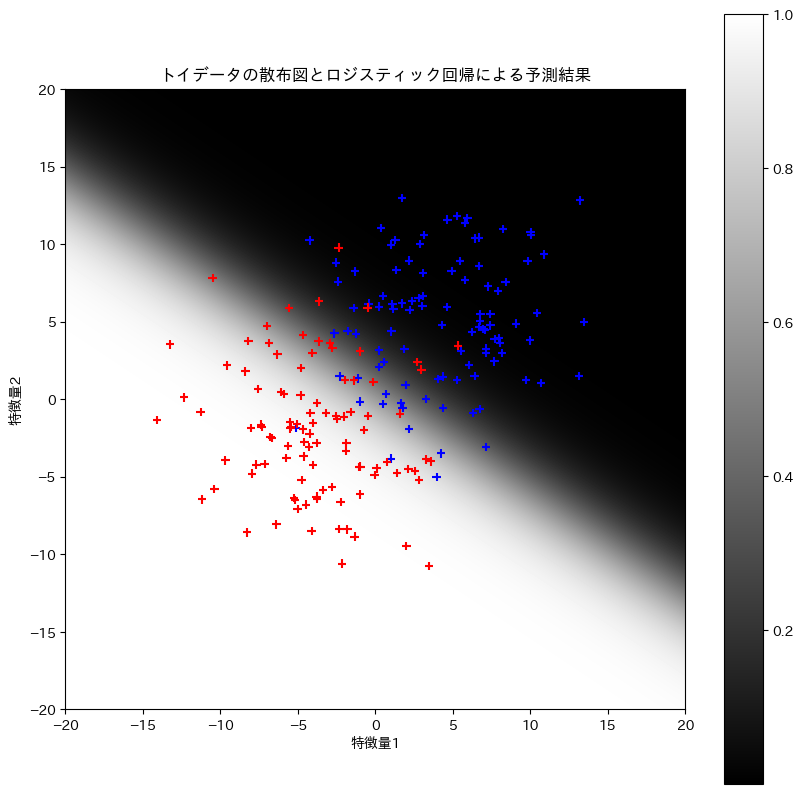

In [8]:
plt.figure(figsize=(10, 10))

plt.imshow(yy.numpy()[::-1, :], extent=[minval, maxval, minval, maxval], cmap='gray')
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=t, marker='+', cmap='bwr')

plt.title('トイデータの散布図とロジスティック回帰による予測結果')
plt.xlabel('特徴量1')
plt.ylabel('特徴量2')